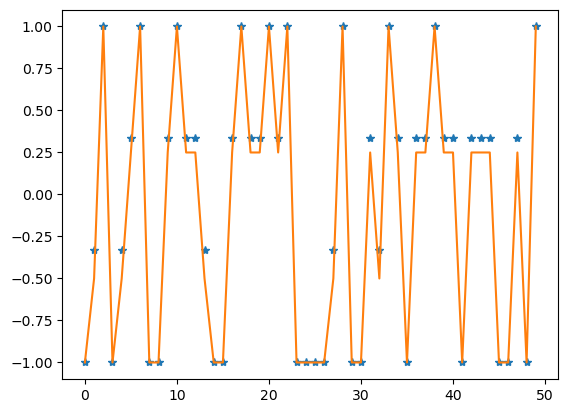

In [1]:
berPam4UncodedMATLAB_0_0_5_18 = np.array([0.140980000000000,0.129900000000000,0.119000000000000,0.108270000000000,0.0977420000000000,0.0874510000000000,0.0774530000000000,0.0678180000000000,0.0586240000000000,0.0499550000000000,0.0418930000000000,0.0345110000000000,0.0278710000000000,0.0220160000000000,0.0169670000000000,0.0127200000000000,0.00924720000000000,0.00649530000000000,0.00439030000000000,0.00284270000000000,0.00175420000000000,0.00102570000000000,0.000564710000000000,0.000290600000000000,0.000138660000000000,6.07860000000000e-05,2.42340000000000e-05,8.68610000000000e-06,2.76320000000000e-06,7.68970000000000e-07,1.84190000000000e-07,3.72860000000000e-08,6.25020000000000e-09,8.47880000000000e-10,9.07160000000000e-11,7.43680000000000e-12,4.52230000000000e-13])
ebn0 = np.arange(0,18.5,0.5)

![title](./pam4MATLAB.png)

In [ ]:
# The following is based on https://scipy-cookbook.readthedocs.io/items/CommTheory.html
import os, sys
ieeeProjectDir = os.environ.get('IEEE8023')
if ieeeProjectDir == None: 
     ieeeProjectDir = "c:/users/omer/802.3/"
sys.path.insert(0, ieeeProjectDir)
import numpy as np
import modulationFunctions as mf
from scipy.special import erfc
import matplotlib.pyplot as plt
berPam2MATLAB_0_1_16 = np.array([0.0786500000000000,0.0562820000000000,0.0375060000000000,0.0228780000000000,0.0125010000000000,0.00595390000000000,0.00238830000000000,0.000772670000000000,0.000190910000000000,3.36270000000000e-05,3.87210000000000e-06,2.61310000000000e-07,9.00600000000000e-09,1.33290000000000e-10,6.81020000000000e-13,9.12400000000000e-16,2.26740000000000e-19])
berPam4MATLAB_0_1_16 = np.array([0.140980000000000,0.119000000000000,0.0977420000000000,0.0774530000000000,0.0586240000000000,0.0418930000000000,0.0278710000000000,0.0169670000000000,0.00924720000000000,0.00439030000000000,0.00175420000000000,0.000564710000000000,0.000138660000000000,2.42340000000000e-05,2.76320000000000e-06,1.84190000000000e-07,6.25020000000000e-09])

SNR_MIN     = 0
SNR_MAX     = 16
M = 4 # Number of PAM levels
pam4SymbolPowerAverage = 1/4 * (1 + 1 + (2/3)**2 + (-2/3)**2)
EbN0_dB    = np.arange(SNR_MIN,SNR_MAX+1,1)
print(len(EbN0_dB))
EbN0_linear        = 10**(EbN0_dB/10.0)  # linear SNR

Pe          = np.empty(EbN0_linear.shape)
BER         = np.empty(EbN0_linear.shape)
PePam4          = np.empty(EbN0_linear.shape)
BerStatsPam4GrayCoded         = np.empty(EbN0_linear.shape)
BerStatsPam4NoGrayCoding      = np.empty(EbN0_linear.shape)

loop = 0
for snr in EbN0_linear:      # SNR loop
    Pe[loop] = 0.5*erfc(np.sqrt(snr))
    pam4Factor = np.sqrt((2/3)**2)
    x = np.sqrt(snr ) #np.sqrt( 6 * np.log2(M) * (1/(M*M- 1)) *snr)
    print(x)
    y = (2*(M-1)/M)
    PePam4[loop] =y  *erfc(pam4Factor * x) # 
    print(PePam4[loop])
    #VEC_SIZE = np.int32(10 * np.ceil(100/Pe[loop]))  # vector length is a function of Pe
    VEC_SIZE = 10000
    # signal vector, new vector for each SNR value
    data = np.random.randint(low = 0, high = 2, size = VEC_SIZE)
    s = 2 * data - 1
    modulatedDataNoGrayCoding, pam4SymbolsNoGrayCoding, _ = mf.modulatePAM4(data, grayCoding=False, precoding=False)
    modulatedDataGrayCoded, pam4SymbolsGrayCoded, _ = mf.modulatePAM4(data, grayCoding=True, precoding=False)
        
    # linear power of the noise; average signal power = 1
    No = 1.0/snr

    # noise
    n = np.sqrt(No/2)*np.random.randn(VEC_SIZE)
    noisePam4 = pam4Factor * (1/snr) * np.random.randn(len(modulatedDataNoGrayCoding))    

    # signal + noise
    x = s + n
    noisyDataNoGrayCoding = modulatedDataNoGrayCoding + noisePam4
    noisyDataGrayCoded = modulatedDataGrayCoded + noisePam4
     

    # decode received signal + noise
    y = np.sign(x)
    pam4SymbolsNoGrayCoding, error = mf.pam4Slice(noisyDataNoGrayCoding)
    pam4SymbolsGrayCoded, error = mf.pam4Slice(noisyDataGrayCoded)
    
    dataRxNoGrayCoding = mf.pam4SymbolsToBits(pam4SymbolsNoGrayCoding, grayCoded= False)
    dataRxGrayCoded = mf.pam4SymbolsToBits(pam4SymbolsGrayCoded, grayCoded= True)
    

    # find erroneous symbols
    err = np.where(y != s)
    error_sum = float(len(err[0]))
    berPam4GrayCoded = np.sum(dataRxGrayCoded != data) / VEC_SIZE
    berPam4NoGrayCoding = np.sum(dataRxNoGrayCoding != data) / VEC_SIZE
    BerStatsPam4GrayCoded[loop] = berPam4GrayCoded
    BerStatsPam4NoGrayCoding[loop] = berPam4NoGrayCoding
    BER[loop] = error_sum/VEC_SIZE
    print ('Eb_No_dB=%4.2f, BER=%10.4e, Pe=%10.4e' % (EbN0_dB[loop], BER[loop], Pe[loop]))
    loop += 1

#plt.semilogy(Eb_No_dB, Pe,'r',Eb_No_dB, BER,'s')
#plt.semilogy(EbN0_dB, Pe,'r',linewidth=2, label = "Theoretical BER using erfc NRZ")
plt.semilogy(EbN0_dB, PePam4,'--r',linewidth=2, label = "Theoretical BER using erfc PAM4")
#plt.semilogy(EbN0_dB, BER,'-s', label = "Experimnetal ber NRZ")
#plt.semilogy(EbN0_dB, berPam2MATLAB_0_1_16, '+g', label = "MATLAB extract NRZ")
plt.semilogy(EbN0_dB, berPam4MATLAB_0_1_16, '-g', label = "MATLAB extract PAM4")
plt.semilogy(EbN0_dB, BerStatsPam4NoGrayCoding, '*r', label = "Experimental BER no gray coding PAM4")
plt.semilogy(EbN0_dB, BerStatsPam4GrayCoded, '+r', label = "Experimental BER WITH gray coding PAM4")
plt.grid(True)
plt.legend()
plt.xlabel('Eb/No (dB)')
plt.ylabel('BER')
plt.show()

In [17]:
berData = []
L = 4
factor = np.sqrt((L ** 2 - 1)/3) # For L == 4 This is the same (?) as (1)^2 + (-1)^2 + (1/3)^2 + (-1/3)^2
factor = 1
for e in ebn0:
    berE = 0
    data = LOCAL_PRNG.randint(low = 0, high = 2, size = SAMPLE_SIZE)
    modulatedData, pam4Symbols, pam4SymbolsPrecoded = mf.modulatePAM4(data, grayCoding=False, precoding=False)
    noisyData,_,_ = cf.additiveWhiteGaussianNoise(modulatedData, length = len(modulatedData), SNRdb = e * factor , prng = LOCAL_PRNG, d = 0.15)
    pam4Symbols, error = mf.pam4Slice(noisyData)
    dataRx = mf.pam4SymbolsToBits(pam4Symbols, grayCoded= False)
    berE = np.sum(dataRx != data) / SAMPLE_SIZE
    berData.append(berE)

In [ ]:
fig, ax = plt.subplots()
pam4Simulated = ax.semilogy(ebn0, np.array(berData), '^b', linewidth = 2, label = 'PAM 4 Uncoded simulated')
pam4UncodedMatlab = ax.semilogy(ebn0, berPam4UncodedMATLAB, '^r', linewidth = 2, label = 'PAM 4 Uncoded MATLAB')
ax.set_ylabel('Output Bit Error Ratio (BER)',fontsize=16)
ax.set_xlabel('Signal to noise ratio (SNR)',fontsize=16)
ax.set_title("Alignment of PAM-4 uncoded to reproduction of MATLAB")    
ax.tick_params(axis='both',  labelsize=16)
ax.grid(True, which="both")
ax.minorticks_on()
plt.show()

In [ ]:
# Now with gray coding
berGrayCoded = []
for e in ebn0:
    berE = 0
    data = LOCAL_PRNG.randint(low = 0, high = 2, size = SAMPLE_SIZE)
    modulatedData, pam4Symbols, pam4SymbolsPrecoded = mf.modulatePAM4(data, grayCoding=True, precoding=False)
    noisyData,_,_ = cf.additiveWhiteGaussianNoise(modulatedData, length = len(modulatedData), SNRdb = e * factor , prng = LOCAL_PRNG, d = 0.15)
    pam4Symbols, error = mf.pam4Slice(noisyData)
    dataRx = mf.pam4SymbolsToBits(pam4Symbols, grayCoded= True)
    berE = np.sum(dataRx != data) / SAMPLE_SIZE
    berGrayCoded.append(berE)

In [ ]:
fig, ax = plt.subplots()
pam4Simulated = ax.semilogy(ebn0, np.array(berData), '^b', linewidth = 2, label = 'PAM 4 Uncoded simulated')
pam4GrayCodedSimulated = ax.semilogy(ebn0, np.array(berGrayCoded), '*g', linewidth = 2, label = 'PAM 4 Gray coded simulated')
pam4UncodedMatlab = ax.semilogy(ebn0, berPam4UncodedMATLAB, '^r', linewidth = 2, label = 'PAM 4 Uncoded MATLAB')
ax.set_ylabel('Output Bit Error Ratio (BER)',fontsize=16)
ax.set_xlabel('Signal to noise ratio (SNR)',fontsize=16)
ax.set_title("Reproduction of MATLAB figure from MATLAB data")    
ax.tick_params(axis='both',  labelsize=16)
ax.grid(True, which="both")
ax.minorticks_on()
plt.show()

In [ ]:
sigma = np.flipud(np.arange(0.1, 0.73, 0.03))

In [ ]:
# Now just sigma
berSigmaPam4 = []
berSigmaNRZ =[]
for s in sigma:
    data = LOCAL_PRNG.randint(low = 0, high = 2, size = SAMPLE_SIZE)
    modulatedData, pam4Symbols, pam4SymbolsPrecoded = mf.modulatePAM4(data, grayCoding=False, precoding=False)
    noisyDataPam4 = modulatedData + np.random.normal(0, s, len(modulatedData))
    noisyDataNRZ = mf.modulatePAM2(data) + np.random.normal(0, s, len(data))
    pam4Symbols, error = mf.pam4Slice(noisyDataPam4)
    dataRxNRZ = mf.slicer(noisyDataNRZ)
    dataRxPam4 = mf.pam4SymbolsToBits(pam4Symbols, grayCoded= False)
    berPam4 = np.sum(dataRxPam4 != data) / SAMPLE_SIZE
    berNRZ = np.sum(dataRxNRZ != data) / SAMPLE_SIZE
    berSigmaPam4.append(berPam4)
    berSigmaNRZ.append(berNRZ)

fig, ax = plt.subplots()
#pam4Simulated = ax.semilogy(ebn0, np.array(berData), '^b', linewidth = 2, label = 'PAM 4 Uncoded simulated')
#pam4GrayCodedSimulated = ax.semilogy(ebn0, np.array(berGrayCoded), '*g', linewidth = 2, label = 'PAM 4 Gray coded simulated')
#pam4UncodedMatlab = ax.semilogy(ebn0, berPam4UncodedMATLAB, '^r', linewidth = 2, label = 'PAM 4 Uncoded MATLAB')
pam4AccordingToSigma = ax.semilogy(sigma, berSigmaPam4, '^k', linewidth = 2, label = 'PAM 4 Uncoded sigma only')
NRZAccordingToSigma = ax.semilogy(sigma, berSigmaNRZ, 'd', linewidth = 2, label = 'NRZ sigma only')
ax.set_ylabel('Output Bit Error Ratio (BER)',fontsize=16)
ax.set_xlabel('Sigma only',fontsize=16)
ax.tick_params(axis='both',  labelsize=16)
ax.grid(True, which="both")
ax.minorticks_on()
ax.invert_xaxis()
plt.show()


In [21]:
def Q(x):
    result = 0.5 * special.erfc((1 / np.sqrt(2)) * x)
    return result
dNrz = 2

snrProakisNRZ_5_2_6 = np.sqrt((dNrz ** 2) /  (2 * sigma))
snrProakisNRZ_5_2_6_DB = 10 * np.log10(np.sqrt((dNrz ** 2) /  (2 * sigma)))
berProakis_5_2_6 = Q(snrProakisNRZ_5_2_6)
fig, ax = plt.subplots()
nrzAccordingToProakis_5_2_6 = ax.semilogy(berProakis_5_2_6, snrProakisNRZ_5_2_6, '^k', linewidth = 2, label = 'NRZ BER as a function of d^2')
ax.set_title('NRZ as a function of d^2, from Proakis')
ax.set_ylabel('Output Bit Error Ratio (BER)',fontsize=16)
ax.set_xlabel('d^2 / 2 * sigma',fontsize=16)
ax.tick_params(axis='both',  labelsize=16)
ax.grid(True, which="both")
ax.minorticks_on()
#ax.invert_xaxis()
plt.show()

NameError: name 'sigma' is not defined

17
1.0
0.5186678792267406
Eb_No_dB=0.00, BER=7.9717e-02, Pe=7.8650e-02
1.1220184543019636
0.4351863359000169
Eb_No_dB=1.00, BER=5.7231e-02, Pe=5.6282e-02
1.2589254117941673
0.3528850616768523
Eb_No_dB=2.00, BER=3.6708e-02, Pe=3.7506e-02
1.4125375446227544
0.2744119672551331
Eb_No_dB=3.00, BER=2.1437e-02, Pe=2.2878e-02
1.5848931924611136
0.20266479307668628
Eb_No_dB=4.00, BER=1.2300e-02, Pe=1.2501e-02
1.7782794100389228
0.1404375751822799
Eb_No_dB=5.00, BER=6.2336e-03, Pe=5.9539e-03
1.9952623149688795
0.08992700002273885
Eb_No_dB=6.00, BER=2.3501e-03, Pe=2.3883e-03
2.2387211385683394
0.052198896679046064
Eb_No_dB=7.00, BER=7.8503e-04, Pe=7.7267e-04
2.51188643150958
0.02681018636194025
Eb_No_dB=8.00, BER=1.8995e-04, Pe=1.9091e-04
2.818382931264454
0.011819010833702747
Eb_No_dB=9.00, BER=3.5477e-05, Pe=3.3627e-05
3.1622776601683795
0.0043036691881149225
Eb_No_dB=10.00, BER=3.9534e-06, Pe=3.8721e-06
3.548133892335755
0.0012332923015263822


C:\Users\Omer\AppData\Local\Temp\ipykernel_13940\278153462.py:37: RuntimeWarning: invalid value encountered in cast
  VEC_SIZE = np.int32(10 * np.ceil(100/Pe[loop]))  # vector length is a function of Pe


ValueError: negative dimensions are not allowed

0.8